# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv(r'C:\Users\poker\OneDrive\Рабочий стол\Data Analysis\Проекты\2 Аренда\real_estate_data.csv', sep = '	')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

Мы имеем базу данных с 23699 объявлениями о продаже квартиры, которые имеют до 22 характеристик. Как нам известно из задания, часть данных вносилась пользователем, часть на основе картографических данных, предположу, что ко вторым относятся:
1. airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
2. cityCenters_nearest — расстояние до центра города (м)
3. parks_around3000 — число парков в радиусе 3 км
4. parks_nearest — расстояние до ближайшего парка (м)
5. ponds_around3000 — число водоёмов в радиусе 3 км
6. ponds_nearest — расстояние до ближайшего водоёма (м)

#### Пропуски
1. ceiling_height (высота потолков (м)) имеем только 14504 из 23699 заполненных значений, 9195 пропусков и заполнить нам их не удастся, слишком индивидуальная информация, не зависящая от остальных известных данных.
2. floors_total (всего этажей в доме) - 86 пропусков (23613 из 23699), так же не восполнимая информация, но, к счастью, отсутсвует очень мало информации.
3. living_area (жилая площадь в квадратных метрах(м²)) - 1903 пропуска (21796 из 23699), но, в случае необходимости, мы сможем категоризировать квартиры по общей площади и вычислить средний процент, который отведен жилой площади. Таким образом у нас получится заполнить данные пропуски.
4. is_apartment (апартаменты) - всего 2775 человек заполнили данную информацию. К счастью, этот параментр имеет буллев тип и может принять лишь положительное или отрицательное значение, и, я вполне уверен, что все львиная доля пропусков на самом деле - отрицательный вариант.
5. kitchen_area (площадь кухни в квадратных метрах (м²)) - 2278 пропусков, которые решаются аналогичным образом с жилой площадью.
6. balcony (число балконов) - как в случае с апартаментами, скорее всего, люди не заполняют поля, когда им "нечем их заполнять", поэтому пропуски мы просто заменим нулями и будем считать, что балконов нет. Ведь если бы мы продавали квартиру, мы бы хотели получить за неё побольше, а для этого нам стоит указать обо всех её достоинствах!
7. locality_name (название населённого пункта) - всего 49 пропусков, но, на мой взгляд, невероятно важной информации, ведь квартира в центре Санкт-Петербурга и в центре села Васюки может "немного" отличаться по цене. Т.к. пропусков крайне мало, считаю, что нам стоит просто избавиться от данных объявлений, т.к. никакой полезной информации они нам не дадут.
8. days_exposition (сколько дней было размещено объявление (от публикации до снятия)) - 3181 пропуск. Так как нам предоставлен Архив данных, то, предположу, что все квартиры были проданы, а значит мы не можем считать, что пропуск появился по причине незавершенности. Информацию получить нам неоткуда.
9. Объеденю пропуски в информации, полученной не от пользователя, а на основе картографических данных: airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest. Подобную информацию сами мы не получим, поэтому все это придется оставить без изменений и, возможно, работать со срезами.

#### Форматы
1. first_day_exposition (дата публикации) - стоит перевести из object в формат даты.
2. floors_total - пострадавшие дома нас не интересуют, рассматриваем лишь целое кол-во этажей - переведем в int.
3. is_apartment - буллевому столбцу bool'ев формат.
4. balcony - даже если пострадал только балкон, нам все равно, рассматриваем только цельные, переведем в int.
5. parks_nearest и ponds_nearest - количество парков и прудов тоже только целочисленное.

## Предобработка данных

Работу над обработкой данных решил произвести проходя по каждому из столбцов и решая, что с ним делать:

### Дата публикации

Переводим из текстового в формат даты:

In [2]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

### Число комнат

Проверим на аномальные значения:

In [3]:
data['rooms'].value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
19       1
16       1
12       1
15       1
Name: rooms, dtype: int64

0 комнат выглядит довольно странно, но на западе под количеством комнат подразумевают количество спален, а студия, по сути, 0-комнатная квартира, проверим предположение:

In [4]:
data.loc[(data['rooms'] == 0) & (data['studio'] == True), 'rooms'] = 1
data['rooms'].value_counts()

1     8185
2     7940
3     5814
4     1180
5      326
6      105
7       59
0       59
8       12
9        8
10       3
11       2
14       2
16       1
19       1
12       1
15       1
Name: rooms, dtype: int64

Из 197 вариант осталось 59, уже лучше.

### Высота потолков

Посмотрим информацию о диапазоне вариантов:

<AxesSubplot:>

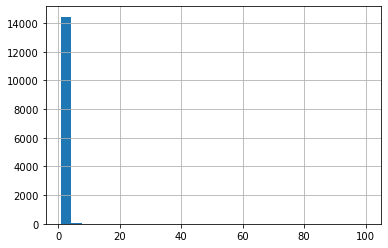

In [5]:
data['ceiling_height'].hist(bins = 30)

<AxesSubplot:>

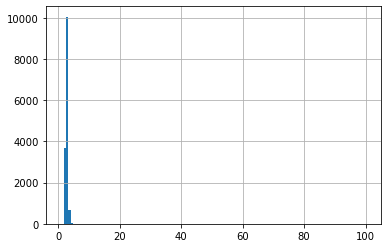

In [6]:
data['ceiling_height'].hist(bins = 130)

Потолки 1м или 100м? И то и то выглядит странным, попробуем определить количетсво квартир, с "фантастическими" потолками:

In [7]:
len(data.query('ceiling_height < 2.0 or ceiling_height > 5.0'))

39

Думаю, от нас не убудет, если мы откажемся от 39 квартир для карликов или гигантов:

In [8]:
#data = data.query('2.0 < ceiling_height <= 5.0 or ceiling_height.isna()')
data = data[(data['ceiling_height'] > 2.0) & (data['ceiling_height'] <= 5.0) | (data['ceiling_height'].isna())]
data = data.reset_index(drop = True)

### Всего этажей

Ставим "маркер" 0 на тех, кто не указал количество этажей в доме и меняем формат, как и планировали:

In [9]:
data['floors_total'] = data['floors_total'].fillna(value = 0.0)
data['floors_total'] = data['floors_total'].astype('int')

### Балконы

Заполним пропуски нулевыми значениями количества балконов а затем изменим формат с float64 на int64, ведь если в квартире пол балкона, появляются вопросы.

In [10]:
data['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

In [11]:
data['balcony'].fillna(value = 0.0, inplace = True)
data['balcony'] = data['balcony'].astype('int')
data['balcony'].unique()

array([0, 2, 1, 5, 4, 3])

<AxesSubplot:>

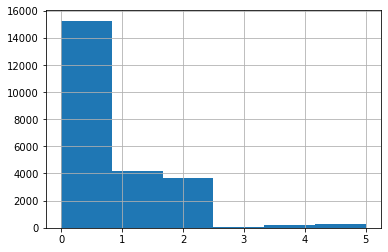

In [12]:
data['balcony'].hist(bins = 6)

### Апартаменты

Как и с балконами, заполняем пропуски на отрицательные значения и меняем формат на булев.

In [13]:
data['is_apartment'].fillna(value = False, inplace = True)
data['is_apartment'] = data['is_apartment'].astype('bool')

### Название населённого пункта

Без зазрения совести удаляю данные объявления о квартирах, т.к. во-первых, их очень мало, во-вторых, уж слишком важная информация отсутствует и без неё эти объявления для анализа мало что стоят:


In [14]:
data.dropna(subset = ['locality_name'], inplace = True)
data = data.reset_index(drop = True)
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Больно часто в уникальных вариантах населенных пунктов мелькают слова "поселок" и "посёлок", есть подозрение, что могут быть дубликаты одних и тех же населенных пунктов. Заодно и на регистр проверим:

In [15]:
len(data['locality_name'].unique())

363

In [16]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.lower()
len(data['locality_name'].unique())

329

Как видим, избавились от 34 дублирующихся названий населенных пунктов.

### Число парков в радиусе 3 км

А вдруг информация о удаленности ближайшего парка у объекта есть, а в показателе parks_around3000 пропуск? Стоит проверить, ведь, как минимум, если ближайший парк дальше 3 км, то логично, что в радиусе 3 км их нет:

P.S. Попутно и формат поменяем.

In [17]:
data.loc[(data['parks_around3000'].isna()) & (data['ponds_nearest'] > 3000), 'parks_around3000'] = 0
data['parks_around3000'] = data['parks_around3000'].astype('Int64', errors = 'ignore')
data['parks_around3000'].unique()

<IntegerArray>
[1, 0, 2, <NA>, 3]
Length: 5, dtype: Int64

### Число водоёмов в радиусе 3 км

Аналогично поступим и с прудами:

In [18]:
data.loc[(data['ponds_around3000'].isna()) & (data['ponds_nearest'] > 3000), 'ponds_around3000'] = 0
data['ponds_around3000'] = data['ponds_around3000'].astype('Int64', errors = 'ignore')
data['ponds_around3000'].unique()

<IntegerArray>
[2, 0, 3, 1, <NA>]
Length: 5, dtype: Int64

### Сколько дней было размещено объявление (от публикации до снятия)

Поменяем формат:

In [19]:
data['days_exposition'] = data['days_exposition'].astype('float32').astype('Int64', errors = 'ignore')

## Рассчёты и добавление результатов в таблицу

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23600 entries, 0 to 23599
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23600 non-null  int64         
 1   last_price            23600 non-null  float64       
 2   total_area            23600 non-null  float64       
 3   first_day_exposition  23600 non-null  datetime64[ns]
 4   rooms                 23600 non-null  int64         
 5   ceiling_height        14440 non-null  float64       
 6   floors_total          23600 non-null  int32         
 7   living_area           21706 non-null  float64       
 8   floor                 23600 non-null  int64         
 9   is_apartment          23600 non-null  bool          
 10  studio                23600 non-null  bool          
 11  open_plan             23600 non-null  bool          
 12  kitchen_area          21342 non-null  float64       
 13  balcony         

### Рассчет и добавление цены за квадратный метр

Для данного рассчета нам нужна информация о площади квартиры и цене, к счастью, вся эта информация у нас присутствует в каждом из объявлений.

In [21]:
data['sqm_price'] = data['last_price'] / data['total_area']
data['sqm_price'].round().head(10)

0    120370.0
1     82921.0
2     92786.0
3    408176.0
4    100000.0
5     95066.0
6     99196.0
7    110545.0
8     87455.0
9     88525.0
Name: sqm_price, dtype: float64

### Добавление информации о дне недели, месяце и годе публикации объявления

Дату добавления объявления мы уже перевели в подходящий формат, поэтому нам осталось лишь взять необходимую информацию из соответствующего столбца:

In [22]:
data['weekday'] = data['first_day_exposition'].dt.weekday  #Создаем столбец с информацией о дне недели
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sqm_price,weekday,month,year
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,16028.0,1,482.0,2,755.0,<NA>,120370.370370,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,18603.0,0,NaN,0,NaN,81,82920.792079,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,False,...,13933.0,1,90.0,2,574.0,558,92785.714286,3,8,2015
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,NaN,9,False,...,6800.0,2,84.0,3,234.0,424,408176.100629,4,7,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,8098.0,2,112.0,1,48.0,121,100000.000000,1,6,2018


### Этаж квартиры

У нас есть вся информация о номере этажа каждой квартиры, но с этажностью домов не все так радужно. Чтож, неуказавших мыделим в отдельную категорию "неизвестно":

In [23]:

def floor_category (data):
    floor = data[0]
    floors_total = data[1]
    if floor == 1:                        # В первую очередь проверяем на первый этаж, так как даже если макс. этаж не указан, 
        return 'Первый'                   # но квартира на 1-ом, то мы это обнаружим и пометим как "Первый", а не "Неизвестный".
    if floors_total == 0:
        return 'Неизвестно'
    if floors_total < floor:
        return 'Воздушный замок'
    if floor == floors_total:
        return 'Последний'
    return 'Другой'
    

data['floor_category'] = data[['floor', 'floors_total']].apply(floor_category, axis=1)
data['floor_category'].value_counts()

Другой        17293
Последний      3318
Первый         2907
Неизвестно       82
Name: floor_category, dtype: int64

В итоге получилось, что 3 квартиры с неуказанным максимальным этажем расположены на 1ом.

### Рассчет соотношения жилой и общей площади, а также отношение площади кухни к общей

#### Жилая и общая площади

Заменим все пропуски на орицательные значения, чтобы объявления с неуказанными значениями не попали в подборку, ограниченную положительными значениями:

<AxesSubplot:>

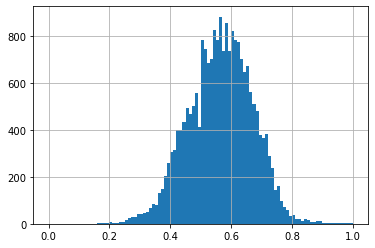

In [24]:
data['living_area'].fillna(value = - 1.0, inplace = True)
data['living_to_total'] = data['living_area'] / data['total_area']  #Добавляем новый столбец с информацией 
                                                                    #о доле жилой зоны в общей площади
data['living_to_total'].hist(bins = 100, range = (0,1))

Выглядит вполне правдоподнобно.



#### Площадь кухни к общей

<AxesSubplot:>

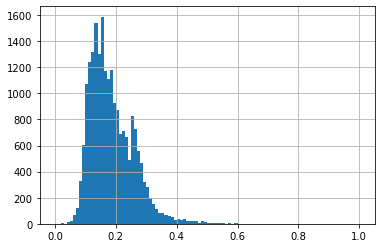

In [25]:
data['kitchen_area'].fillna(value = - 1.0, inplace = True)
data['kitchen_to_total'] = data['kitchen_area'] / data['total_area']  #Добавляем новый столбец с информацией 
                                                                      #о доле площади кухни в общей.
data['kitchen_to_total'].hist(bins = 100, range = (0,1))

Мы видим основной пик на уровне ~17% и небольшой второй пик в районе 25%. Вполне возможно, что его создают малогарабитные квартиры, как правило, кухня всегда имеет какой-то допустимый минимум в кв.м., которого застройщики придерживаются, и при уменьшении площади квартиры увеличивается доля кухни.

## Исследовательский анализ данных

### Изучение основных параметров

#### Площадь квартиры

count    23600.000000
mean        60.303630
std         35.540855
min         12.000000
25%         40.000000
50%         52.000000
75%         69.702500
max        900.000000
Name: total_area, dtype: float64

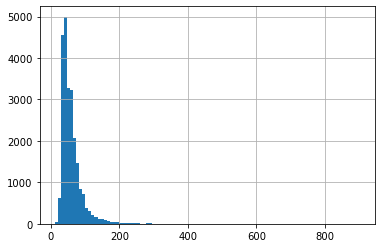

In [26]:
data['total_area'].hist(bins = 100)
data['total_area'].describe()

Как видно из гистограммы, основная доля квартир имеют площадь в пределах 40-100 кв.м., но очевидны выбросы единичных экземпляров от 300 до 900 кв. м.

#### Цена

Т.к. цены указаны в слишком больших цифрах, отображающихся не очень удобно, построим гистограмму и рассмотрим информацию о ценах не в руб. а в млн. руб.:

count    23600.000000
mean         6.527884
std         10.824743
min          0.012190
25%          3.400000
50%          4.650000
75%          6.799000
max        763.000000
Name: last_price, dtype: float64

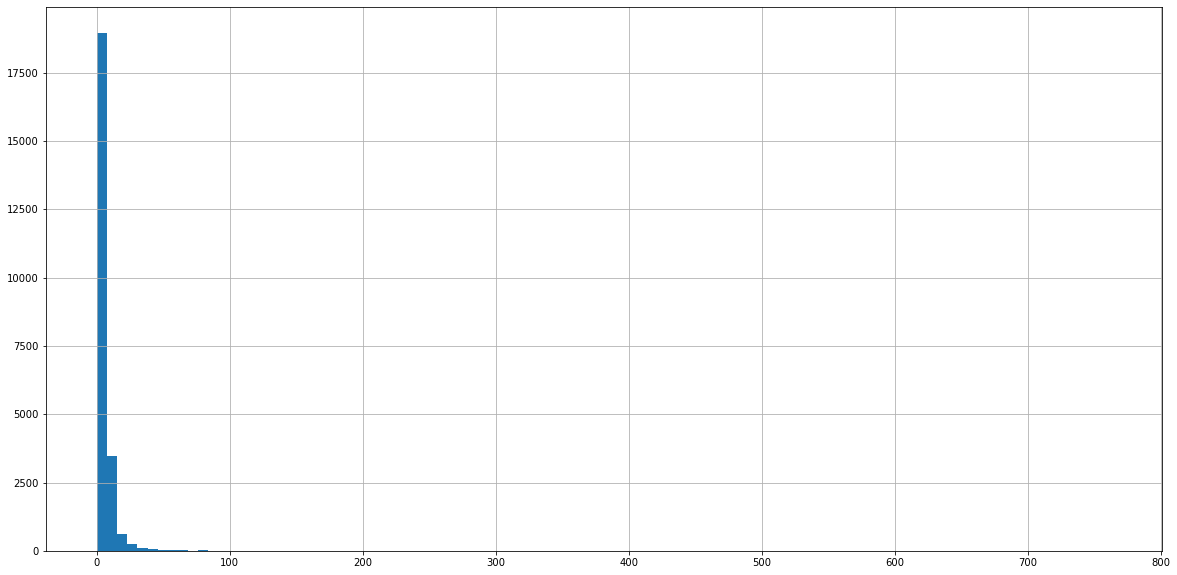

In [27]:
(data['last_price'] / 1000000).hist(bins = 100, figsize = (20,10))
(data['last_price'] / 1000000).describe()

In [28]:
data.sort_values(by = 'last_price').head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,sqm_price,weekday,month,year,floor_category,living_to_total,kitchen_to_total
8758,7,12190.0,109.0,2019-03-20,2,2.75,25,32.0,25,False,...,0,NaN,8,111.834862,2,3,2019,Последний,0.293578,0.371560
17394,7,430000.0,30.4,2019-04-22,1,NaN,2,16.0,1,False,...,<NA>,NaN,<NA>,14144.736842,0,4,2019,Первый,0.526316,0.197368
14860,5,430000.0,54.0,2018-06-26,2,NaN,3,-1.0,3,False,...,<NA>,NaN,44,7962.962963,1,6,2018,Последний,-0.018519,-0.018519
16219,18,440000.0,40.0,2018-07-10,1,NaN,5,-1.0,1,False,...,<NA>,NaN,45,11000.000000,1,7,2018,Первый,-0.025000,-0.025000
17612,0,450000.0,36.5,2018-02-01,1,NaN,5,17.3,4,False,...,<NA>,NaN,120,12328.767123,3,2,2018,Другой,0.473973,0.232877
9544,7,450000.0,43.4,2018-08-31,2,NaN,5,30.3,3,False,...,<NA>,NaN,96,10368.663594,4,8,2018,Другой,0.698157,0.126728
5675,7,450000.0,42.0,2017-07-31,2,NaN,1,23.0,1,False,...,<NA>,NaN,233,10714.285714,0,7,2017,Первый,0.547619,0.138095
16164,14,450000.0,38.5,2018-07-11,2,2.65,2,-1.0,1,False,...,<NA>,NaN,45,11688.311688,2,7,2018,Первый,-0.025974,-0.025974
18799,1,470000.0,41.0,2018-02-11,1,NaN,5,32.0,3,False,...,<NA>,NaN,46,11463.414634,6,2,2018,Другой,0.780488,0.219512
21823,0,470000.0,37.0,2018-02-18,1,NaN,3,-1.0,3,False,...,<NA>,NaN,45,12702.702703,6,2,2018,Последний,-0.027027,-0.027027


И снова выбросы квартир с огромными ценами растягивают наш дишу гистограмму, хотя очевидно, что основной диапозон цен лежит в пределах 7 млн. руб.


#### Число комнат

In [29]:
data['rooms'].value_counts()

1     8156
2     7907
3     5788
4     1173
5      324
6      104
7       59
0       58
8       12
9        8
10       3
11       2
14       2
16       1
19       1
12       1
15       1
Name: rooms, dtype: int64

<AxesSubplot:>

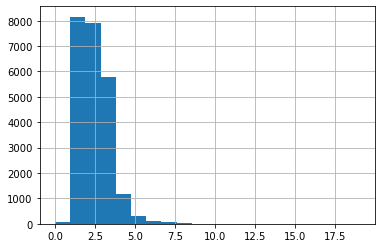

In [30]:
data['rooms'].hist(bins = 20)

На мой взгляд, числовое представление более информативно при малом количестве вариантов значений. Очевидно, что преобладают 1, 2-ух и 3-ёх комнатные квартиры.

#### Высота потолков

На предообработке данных мы уже избавились от выделяющихся и явно неправдивых значений и теперь посмотрим, как выглядит ситуация:

<AxesSubplot:>

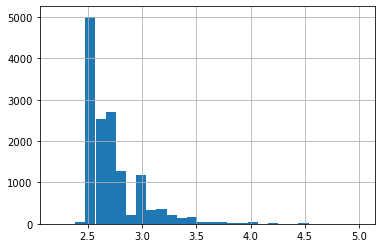

In [31]:
data['ceiling_height'].hist(bins = 30)

Вполне реалестично - значительная часть квартир имеет потолки высотой в пределах 2.5-2.8 метров.


### Исследование времени продажи квартиры

Для начала ознакомимся с гистограммой для времени продажи квартиры:

<AxesSubplot:>

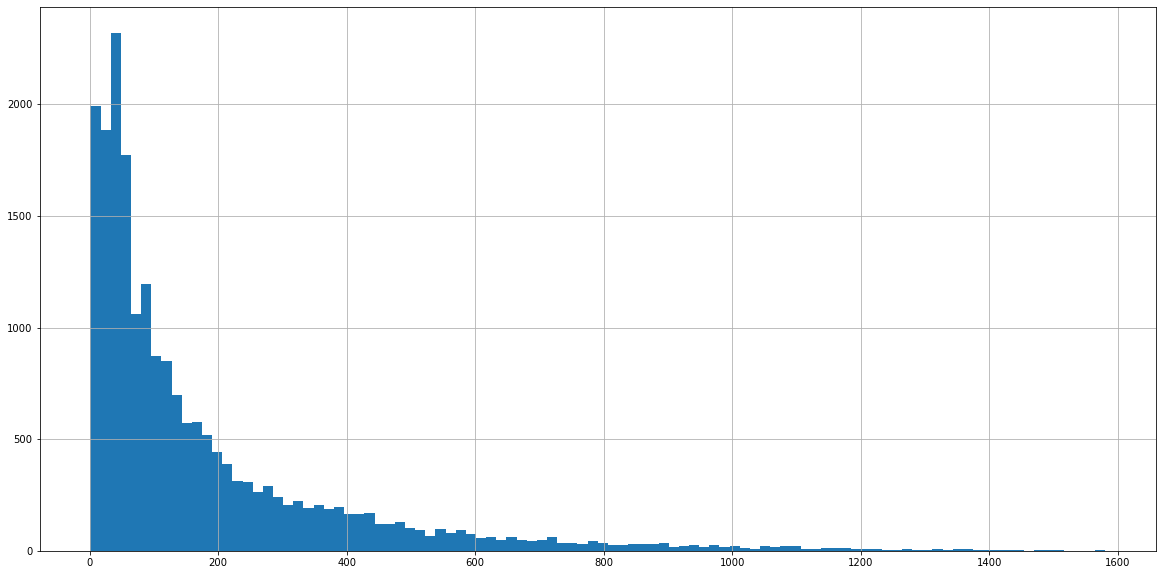

In [32]:
data['days_exposition'].hist(bins = 100, figsize = (20,10))

Большая часть квартир, как мы видим, продается в первый месяц-два от даты размещения квартиры, но какой срок можно назвать чрезвычайно долгим, а какой, даже при таком большом кол-ве квартир, проданных в первый месяц, все равно можно назвать чрезвычайно быстрыми? Ответить на этот вопрос поможет диаграмма размаха:

count    20431.000000
mean       180.775733
std        219.838752
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

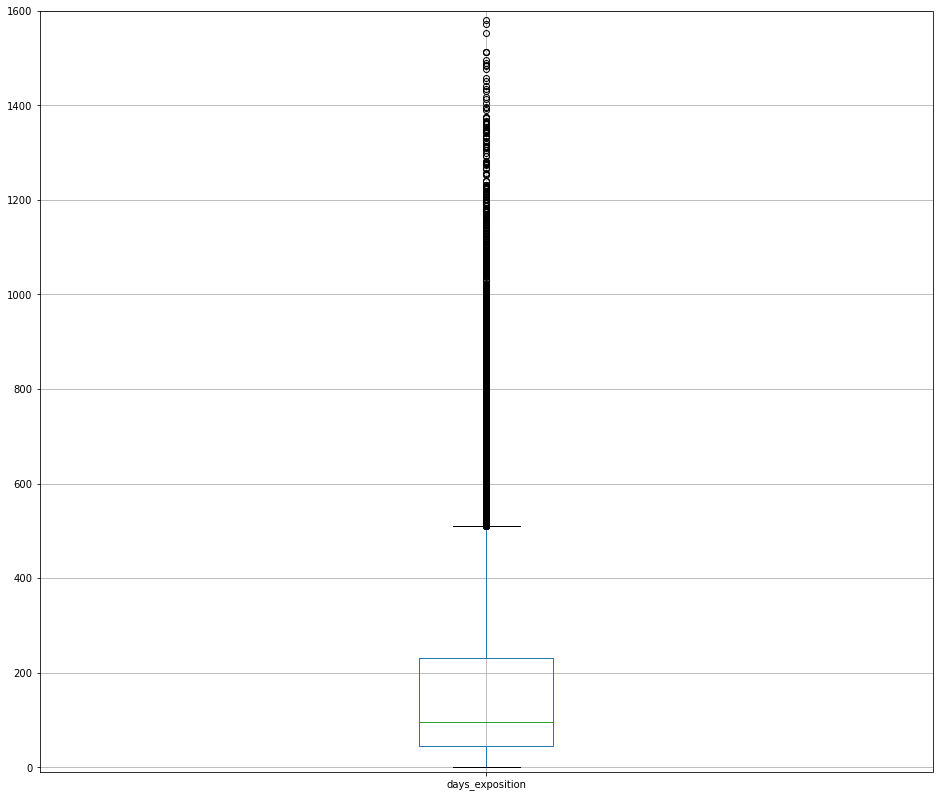

In [33]:
import matplotlib.pyplot as plt
plt.ylim(-10, 1600)
data['days_exposition'].plot.box(figsize = (16,14), grid = True) 
data['days_exposition'].describe()

Среднее арифметическое значение 181 день (около полу года) на продажу квартиры, но при этом медианное 95 дней. Практически двойная разница этих показателей говорит нам о том, что мы имеем дело с большим количеством "висяков" - квартир, которые продавались очень долго.

Как мы видим, значения, выше границы ~500 дней коробка с уcами уже считает выбросами, или, в нашем случае, чрезвычайно долгими продажами. Что же касается чрезвычайно быстрых продаж, то тут сложнее, нижний ус упирается в 0, а нижняя граница коробки находится на уровне 45 дней, учитывая, что с момента первого звонка по объявлению до снятия объявления (а значит и факта продажи квартиры) может пройти пройти довольно много времени, затрачиваемого на визуальный осмотр квартиры, ознокамление с документами и принятие решения о дорогостоящей покупке, а иногда и оформление документов на ипотеку, то 45 дней это действительно очень быстро, давайте примем эту цифру за границу, ниже которой продажа квартиры состоялась чрезвычайно быстро.

### Редкие и выбивающиеся значения

Чтож, давайте создадим новую базу данных, в которой мы оставим все данные после фильтрации от "выбросов". Чуть раньше мы уже избавились от квартир с аномальными потолками, теперь пришло время поискать отклонения и в других параметрах:

<AxesSubplot:>

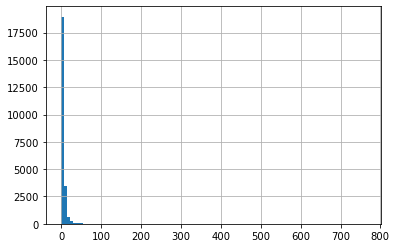

In [34]:
(data['last_price']/1000000).hist(bins = 100)

<AxesSubplot:>

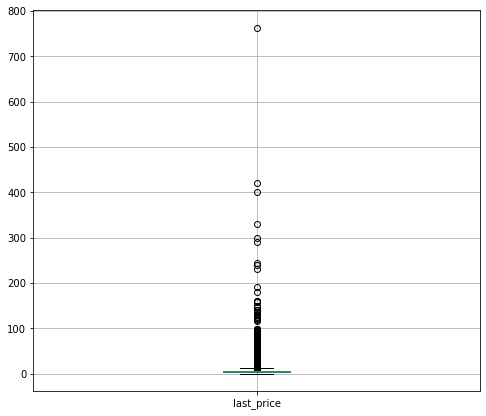

In [35]:
(data['last_price']/1000000).plot.box(figsize = (8,7), grid = True) 

Хоть в существование квартир с ценой 200, 300 или даже 700 млн. мы все точно верим, но для нашей статистики они могут быть лишними, т.к. они точно не для рядовых граждан, для которых мы стараемся. Ограничим цену хотя бы 50 млн.:

<AxesSubplot:>

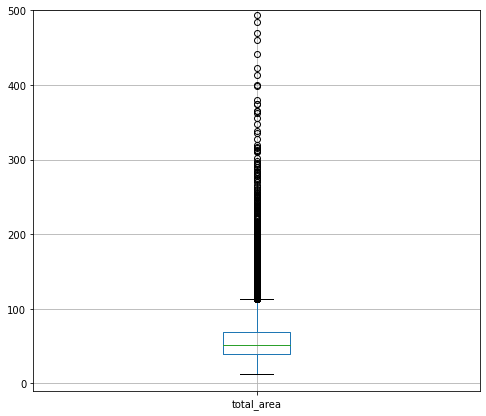

In [36]:
filtered_data = data[data['last_price'] < 50000000]
plt.ylim(-10, 500)
filtered_data['total_area'].plot.box(figsize = (8,7), grid = True) 

Квартиры площадью больше 200 кв.м. это уже, конечно, в одиночку не убраться.

<AxesSubplot:>

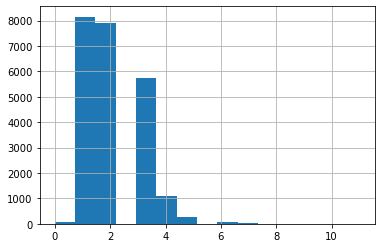

In [37]:
filtered_data = filtered_data[filtered_data['total_area'] < 200]
filtered_data['rooms'].hist(bins = 15)

"Вы ищите квартиру с 10 комнатами или 12?"

"Ограничусь 5ью"

P.S. Но и от квартир с 0 комнат мы избавимся, студии мы вытащили из этой "черной дыры"

<AxesSubplot:>

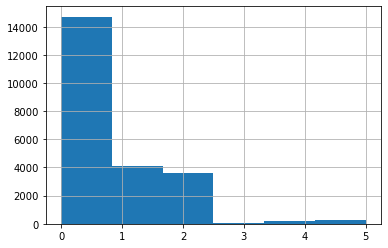

In [38]:
filtered_data = filtered_data[(filtered_data['rooms'] < 5) & (filtered_data['rooms'] > 0)]

filtered_data['balcony'].hist(bins = 6)

Ни разу не видел квартир с больше чем 3 болконами (честно говоря, и с 3мя не видел), поэтому предположу, что это скорей исключение из правил и стоит избавиться от квартир с обзором на 360 градусов.

count     22448.000000
mean      97214.072658
std       38904.983646
min         111.834862
25%       76362.301428
50%       94720.496894
75%      113434.595427
max      848484.848485
Name: sqm_price, dtype: float64

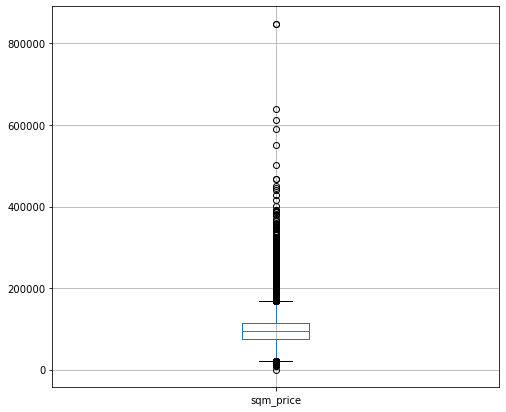

In [39]:
filtered_data = filtered_data[filtered_data['balcony'] <= 3]

filtered_data['sqm_price'].plot.box(figsize = (8,7), grid = True) 
filtered_data['sqm_price'].describe()

In [40]:
filtered_data = filtered_data[filtered_data['sqm_price'] < 250000]
filtered_data = filtered_data[((filtered_data['locality_name'] == 'санкт-петербург') & 
                               (filtered_data['sqm_price'] > 40000)) | 
                              (filtered_data['locality_name'] != 'санкт-петербург')]

<font color='purple'> Тут я добавил строку, отфильтровывающую квартиры в Питере с ценой за кв.м. меньше 40 тыс. рублей.

In [41]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22281 entries, 0 to 23599
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22281 non-null  int64         
 1   last_price            22281 non-null  float64       
 2   total_area            22281 non-null  float64       
 3   first_day_exposition  22281 non-null  datetime64[ns]
 4   rooms                 22281 non-null  int64         
 5   ceiling_height        13546 non-null  float64       
 6   floors_total          22281 non-null  int32         
 7   living_area           22281 non-null  float64       
 8   floor                 22281 non-null  int64         
 9   is_apartment          22281 non-null  bool          
 10  studio                22281 non-null  bool          
 11  open_plan             22281 non-null  bool          
 12  kitchen_area          22281 non-null  float64       
 13  balcony         

**Вывод**

В итоге мы избавились от ~1400 предложений по квартирам с выдающимися значениями хотя бы в одном из параметров. Это позволит нам вевести статистику без влияния единичных уникальных предложений.

### Какие факторы больше всего влияют на стоимость квартиры?

#### Влияние площади на цену

,total_area,last_price
total_area,1.000000,0.795983
last_price,0.795983,1.000000


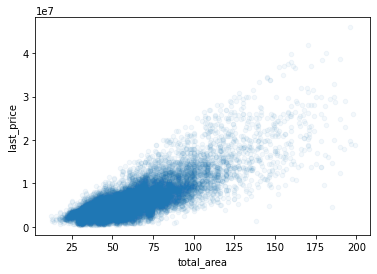

In [42]:
filtered_data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.05) 
filtered_data[['total_area', 'last_price']].corr()

Чётко прослеживается корреляция между площадью квартиры и финальной ценой продажи ведь это ключевой фактор в формировании цены! А значение в 0.79 только это подтверждает.

#### Влияние количества комнат на цену

In [43]:
(filtered_data.pivot_table(index = ['rooms'], values = 'last_price') / 1000000).round(1).astype('str') + ' млн'

,last_price
rooms,
1,3.8 млн
2,5.4 млн
3,7.3 млн
4,10.5 млн


Как мы видим, количество комнат сильно влияет на цену квартиры, но это не мудрено, с увеличением числа комнат увеличивается и площадь, а платим мы именно за кв.м.

#### Влияние удаленности от центра на цену

,cityCenters_nearest,last_price
cityCenters_nearest,1.000000,-0.337075
last_price,-0.337075,1.000000


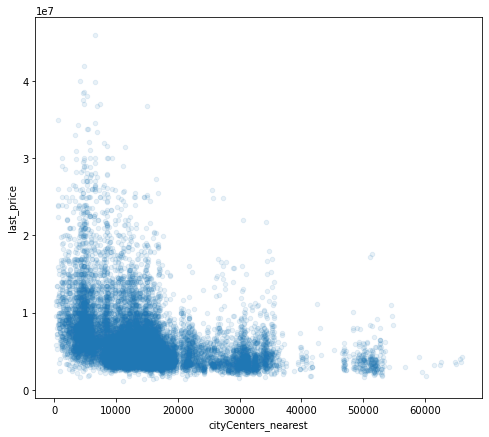

In [44]:
filtered_data.plot(x='cityCenters_nearest', y='last_price', kind='scatter', alpha=0.1, figsize = (8,7))
filtered_data[['cityCenters_nearest', 'last_price']].corr()

Показатель корреляции в -0.33 чётко указывает на обратную зависимость данных характеристик квартиры, а диаграмма рассеяния показывает нам как падает цена при удалении от центра:
1. после 20 тыс. м. цена перестает зависеть от удаленности, скорее всего это и есть граница города
2. Макимально дорогие квартиры сконцентрированы в самом центре Питера

#### Зависимость цены от того, на каком этаже расположена квартира

In [45]:
(filtered_data.pivot_table(index = ['floor_category'], values = 'last_price') / 1000000).round(2).astype('str') + ' млн'

,last_price
floor_category,
Другой,5.75 млн
Неизвестно,6.41 млн
Первый,4.33 млн
Последний,5.21 млн


**Вывод**

Думаю, что никого не удивит, что мы подтвердили теорию, что:
1. Квартиры не на 1-м или последнем этаже в стреднем дороже (5.75 млн. средняя цена)
2. Квартиры на первом этаже самые дешевые (4.32 млн.)
3. На последнем средние по цене, скидочку застройщику приходится делать (5.21 млн.)

P.S. 4ая категория, которую я добавил по своей инициативе, состоящая из квартир НЕ 1го этажа, но с неизвестным последним оказалась самой дорогой. Видимо, богатым людям слишком лениво заполнять всю информацию о своей квартире.

#### Зависимость от дня недели

In [46]:
(filtered_data.pivot_table(index = ['weekday'], values = 'last_price') / 1000000).round(2).astype('str') + ' млн'

,last_price
weekday,
0,5.52 млн
1,5.53 млн
2,5.57 млн
3,5.57 млн
4,5.44 млн
5,5.28 млн
6,5.41 млн


<AxesSubplot:>

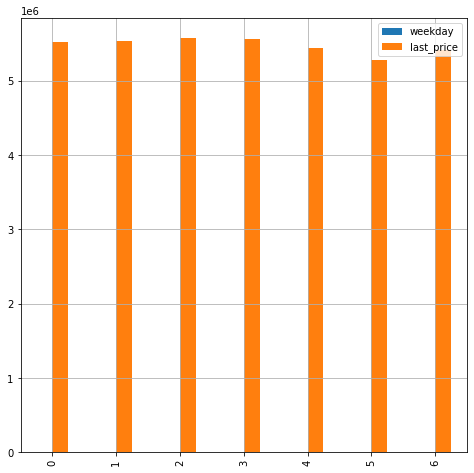

In [47]:
filtered_data.pivot_table(index = ['weekday'], values = 'last_price').reset_index().plot(kind = 'bar', figsize = (8, 8), grid = True)

**Вывод**

Хоть вне зависимости от дня недели средняя цена на квартиру варьируется в пределах 5.27-5.57 млн. стоит все же отметить, что квартиры, выставленные на продажу в выходные, все же продаются чуть дешевле.

#### Зависимость от месяца

In [48]:
(filtered_data.pivot_table(index = ['month'], values = 'last_price') / 1000000).round(2).astype('str') + ' млн'

,last_price
month,
1,5.53 млн
2,5.49 млн
3,5.45 млн
4,5.59 млн
5,5.5 млн
6,5.16 млн
7,5.52 млн
8,5.5 млн
9,5.69 млн


<AxesSubplot:>

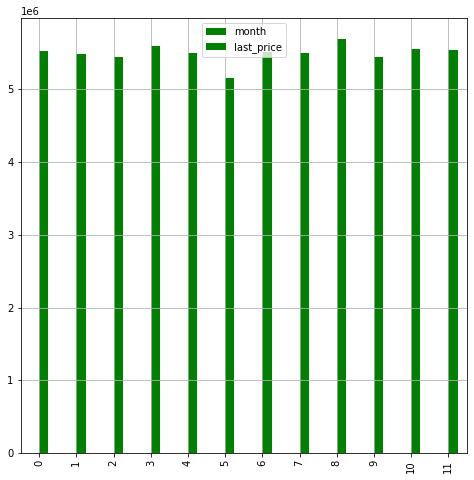

In [49]:
filtered_data.pivot_table(index = ['month'], values = 'last_price').reset_index().plot(kind = 'bar', figsize = (8, 8), grid = True, color = 'green')

**Вывод**

И снова средняя цена на квартиру почти не меняется от месяца к месяцу и только в июне цена немного проседает, скорее всего это связано с сезоном отпусков и понижением спроса на квартиры в летний период. Давайте убедимся в верности наших выводов и взглянем на корреляцию, которая, скорее всего стремится к 0:

In [50]:
filtered_data[['month', 'last_price']].corr()

,month,last_price
month,1.000000,0.005322
last_price,0.005322,1.000000


#### Зависимость от года

In [51]:
(filtered_data.pivot_table(index = ['year'], values = 'last_price') / 1000000).round(2).astype('str') + ' млн'

,last_price
year,
2014,9.1 млн
2015,6.27 млн
2016,5.5 млн
2017,5.42 млн
2018,5.34 млн
2019,5.75 млн


<AxesSubplot:xlabel='year'>

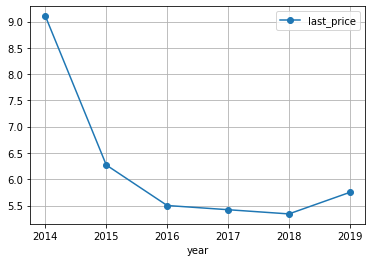

In [52]:
(filtered_data.pivot_table(index = ['year'], values = 'last_price') / 1000000).round(2).plot(style = '-o', grid = True)

**Вывод**

Тут мы видим четкое влияние мировой политики на цены на недвижимость, 2014 год многие люди могут отметить черным уветом в каледаре, потому что наша валюта полетела в трубу, что сопровождалось массовой скупкой недвижимости, а затем... пустота.
Давайте откинем этот год и рассмотрим 2015-2019: здесь мы видим, что вплоть до 2018 года цены на недвижимость неуклонно понижались, и только 2019 решил напомнить, что недвижимость всегда считалась одним из лучших актив для инвестирования.

### Цены кв.м. в разных населенных пунктах

Итак, посмотрим 10 населенных пунктов с самым большим количеством объявлений:

<AxesSubplot:ylabel='ad_numb'>

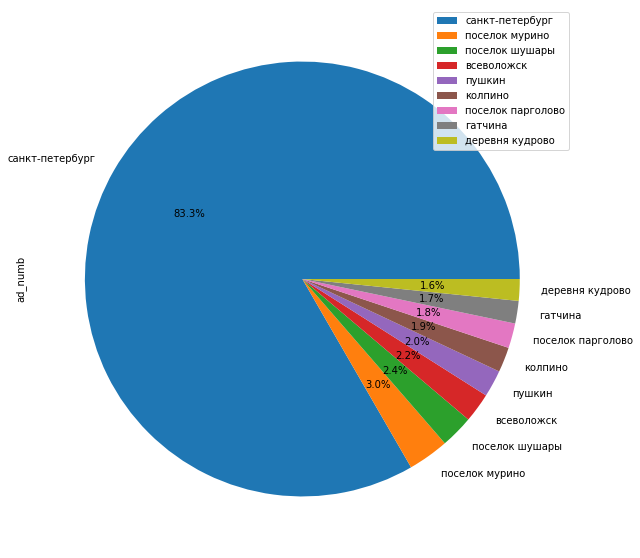

In [53]:
new_filtered_data = filtered_data[['locality_name', 'sqm_price']].groupby(by = 'locality_name').count().sort_values(
    by = 'sqm_price', ascending = False)
new_filtered_data.columns = ['ad_numb']
new_filtered_data = new_filtered_data.query('ad_numb > 234')
new_filtered_data.plot(y = 'ad_numb', kind = 'pie', figsize = (10, 10), autopct='%1.1f%%')

<AxesSubplot:xlabel='locality_name'>

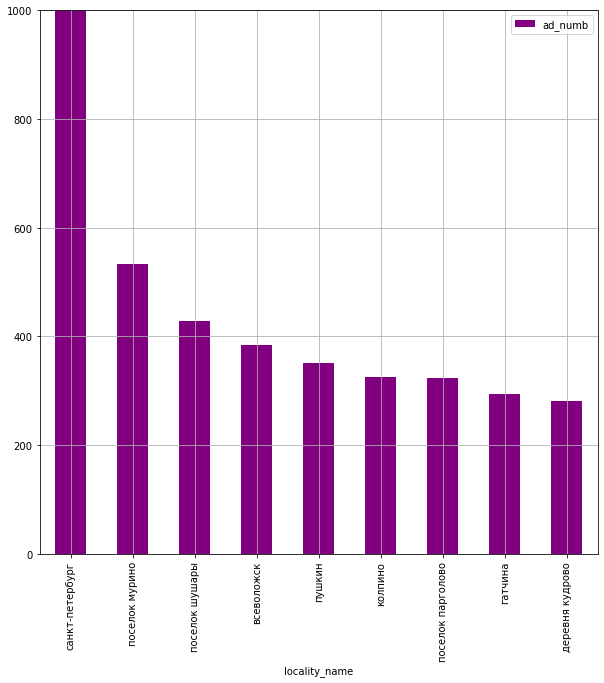

In [54]:
new_filtered_data.plot(y = 'ad_numb', kind = 'bar', figsize = (10, 10), grid = True, color = 'purple', ylim = (0, 1000))

In [55]:
new_filtered_data_price = filtered_data[['locality_name', 'sqm_price']].groupby(by = 'locality_name').mean()
new_filtered_data['sqm_mean_price'] = new_filtered_data_price['sqm_price']
new_filtered_data.sort_values(by = 'sqm_mean_price', ascending = False)

,ad_numb,sqm_mean_price
locality_name,,
санкт-петербург,14609,109872.405595
пушкин,351,102701.317340
деревня кудрово,282,92552.738495
поселок парголово,323,90348.996281
поселок мурино,533,85713.694361
поселок шушары,429,78878.457462
колпино,326,75268.557813
гатчина,294,68705.632240
всеволожск,384,67264.320626


**Вывод**

Как ни странно, в Санкт-Петербурге самый дорогой квадратный метр, а самый дешевый из топ-10 населенных пунктов по кол-ву объявлений - Выборг!

### Влияние удаленности от центра Питера на цену квартиры

В первую очередь отмечу, что нам стоит работать с первоначальной базой данных, а не отфильтрованной, т.к., скорее всего, те дорогущие квартиры, что мы отфильтровали, как раз находятся в центре и сильно влияют на цены в этом районе:

<AxesSubplot:xlabel='cityCenters_nearest_km'>

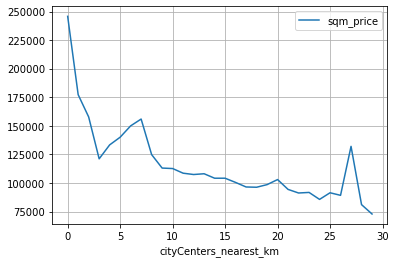

In [56]:
spb_data = data[data['locality_name'] == 'санкт-петербург']
spb_data = spb_data.reset_index(drop = True)
del spb_data['locality_name']                           # Удалим столбец, так как везде значение одинаковое и нам не интересно
spb_data['cityCenters_nearest_km'] = (spb_data['cityCenters_nearest'] / 1000).round()
spb_data[['cityCenters_nearest_km', 'sqm_price']].groupby(by = 'cityCenters_nearest_km').mean().reset_index().plot(
    x = 'cityCenters_nearest_km', y = 'sqm_price', grid = True)

Как мы видим, до 9 километра сильные колебания в цене, но дальше понижение цены гораздо больее плавное. Однако, скачёк в районе 27 км выглядит довольно подозрительно, стоит посмотреть что творится с ценами за кв. м. за пределами 25го километра:

<AxesSubplot:>

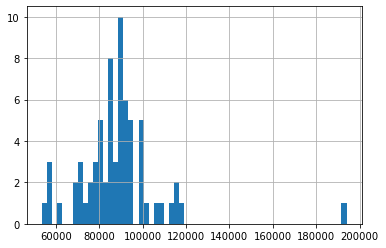

In [57]:
new_spb_data = spb_data[spb_data['cityCenters_nearest_km'] > 25]
new_spb_data['sqm_price'].hist(bins = 60)

Выглдит довольно неплохо, за исключением одной квартиры с ценой более 190 тыс. за кв.м., посмотрим на нее?

In [58]:
new_spb_data.sort_values(by = 'sqm_price', ascending = False).head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,sqm_price,weekday,month,year,floor_category,living_to_total,kitchen_to_total,cityCenters_nearest_km
469,13,14350000.0,74.00,2017-11-28,2,3.13,5,30.0,3,False,...,NaN,128,193918.918919,1,11,2017,Другой,0.405405,0.337838,27.0
12724,10,2903659.0,24.67,2018-10-10,1,NaN,0,16.0,6,False,...,492.0,136,117700.000000,2,10,2018,Неизвестно,0.648561,-0.040535,26.0


"Удивительный" продавец, стоит исключить его из данных:

In [59]:
# КОД РЕВЬЮЕРА
data.loc[469]['locality_name']

'санкт-петербург'

In [60]:
#spb_data = spb_data.drop(spb_data[(spb_data['sqm_price'] > 190000) & (spb_data['cityCenters_nearest_km'] > 25)].index)
#spb_data[['cityCenters_nearest_km', 'sqm_price']].groupby(by = 'cityCenters_nearest_km').mean().reset_index().plot(
#    x = 'cityCenters_nearest_km', y = 'sqm_price')

**Вывод**

Теперь смело можно утрверждать, что на рынке недвижимости центр ограничен 9и километровым радиусом!

<font color='purple'> **Новый вывод**
    
Наибольшее влияние удаленности от центра города на цену наблюдается в районе первыз 3 км. города, затем начинаются колебания, скорее всего, основанные на ценах жилых комплексов разной степени элитности, но, в целом, цена гораздо меньше зависит от расстояния до центра, поэтому установим границу на отметке 3 км.

### Анализ квартир в центре города

В первую очередь создадим новую БД центра города:

In [61]:
centre_spb_data = spb_data[spb_data['cityCenters_nearest_km'] < 4]
len(centre_spb_data)

877

#### Изучение основных параметров квартир в центре
##### Площадь

count    877.000000
mean      98.725108
std       56.570858
min       12.000000
25%       63.300000
50%       85.000000
75%      116.500000
max      517.000000
Name: total_area, dtype: float64

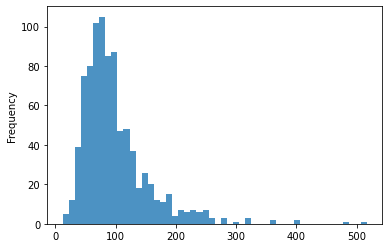

In [62]:
centre_spb_data['total_area'].plot(y = 'time_spent', kind = 'hist', bins = 50, alpha=0.8)
centre_spb_data['total_area'].describe()

count    15693.000000
mean        64.702941
std         40.255678
min         12.000000
25%         42.000000
50%         55.000000
75%         74.600000
max        900.000000
Name: total_area, dtype: float64

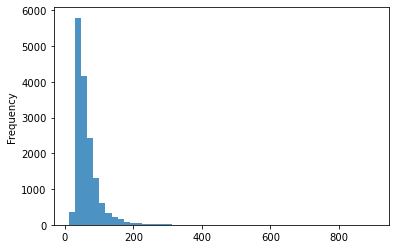

In [63]:
spb_data['total_area'].plot(y = 'time_spent', kind = 'hist', bins = 50, alpha=0.8)
spb_data['total_area'].describe()

Как мы можем видить, в центре города продаются большие по площади квартиры: медианное значение 72.6 кв.м. против 55 кв.м. по всему городу чётко дает это понять.
##### Цена

count    877.000000
mean      16.320751
std       26.483815
min        2.100000
25%        7.300000
50%        9.800000
75%       15.000000
max      401.300000
Name: last_price, dtype: float64

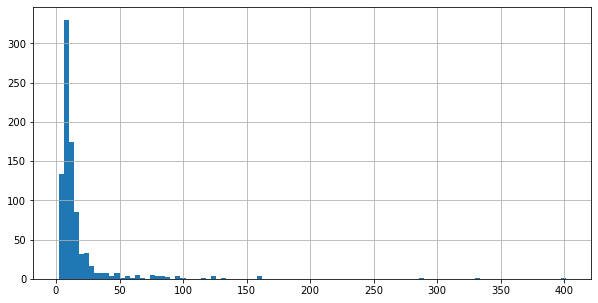

In [64]:
(centre_spb_data['last_price'] / 1000000).hist(bins = 100, figsize = (10,5))
(centre_spb_data['last_price'] / 1000000).describe()

count    15693.000000
mean         8.039878
std         12.923616
min          0.012190
25%          4.200000
50%          5.500000
75%          8.150000
max        763.000000
Name: last_price, dtype: float64

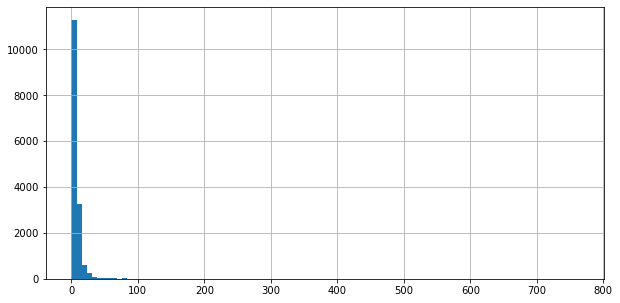

In [65]:
(spb_data['last_price'] / 1000000).hist(bins = 100, figsize = (10,5))
(spb_data['last_price'] / 1000000).describe()

Схожая с площадью ситуация и с ценой: медианная 9.8 м. руб. в центре, против 5.5 м. руб. по всему городу

##### Число комнат

In [66]:
centre_spb_data['rooms'].median()

3.0

In [67]:
spb_data['rooms'].median()

2.0

На мой взгляд, самая показательная информация это "среднее по больнице" в данном случае: все просто, в среднем на пол комнаты больше имеют квартиры в центре относительно всего города в целом.

##### Высота потолков

<AxesSubplot:>

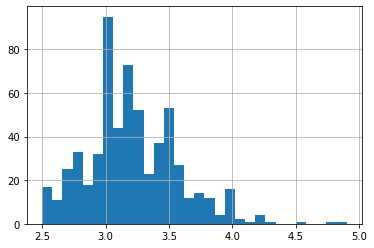

In [68]:
centre_spb_data['ceiling_height'].hist(bins = 30)

<AxesSubplot:>

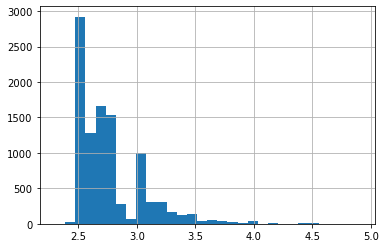

In [69]:
spb_data['ceiling_height'].hist(bins = 30)

Сразу же бросается в глаза: что если твоя квартира в центре, то потолки должны быть 3 метра, а если за пределами, то 2.5 м. Видимо, так показывается статус, надеюсь с поребриками ситуация не идентична, а то в центре бампер можно оставить, если с парковкой проблемы.

#### Факторы, влияющие на стоимость квартиры в центре

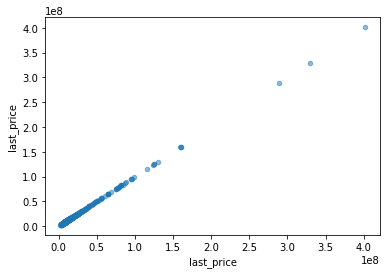

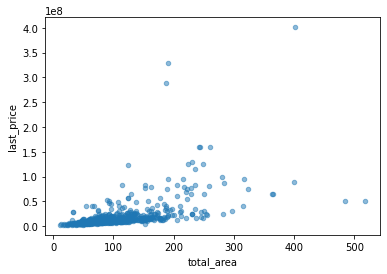

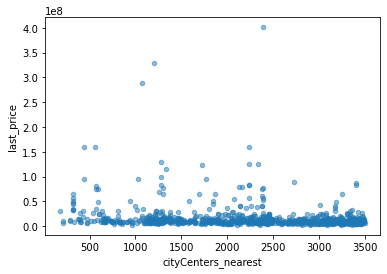

In [70]:
new_centre_spb_data = centre_spb_data[[
    'last_price', 
    'total_area', 
    'cityCenters_nearest'
]]

for column in new_centre_spb_data.columns:
    new_centre_spb_data.plot(x = column, y = 'last_price', kind='scatter', alpha=0.5)
    

In [71]:
for column in new_centre_spb_data.columns:
    print(new_centre_spb_data[[column, 'last_price']].corr())

            last_price  last_price
last_price         1.0         1.0
last_price         1.0         1.0
            total_area  last_price
total_area    1.000000    0.565496
last_price    0.565496    1.000000
                     cityCenters_nearest  last_price
cityCenters_nearest             1.000000   -0.164889
last_price                     -0.164889    1.000000


- Площадь: мы видим сильную корреляцию цены и площади квартиры,однако она ниже чем по всему городу, скорее всего это связано с тем, что в центре города больше других факторов, влияющих на цену элитного жилья, что снимает влияние площади.

- Удаленность от центра: тут мы продолжаем наблюдать обратную корреляцию, однако значительно менее выраженную.

In [72]:
centre_spb_data = centre_spb_data.query('rooms != 0')
(centre_spb_data.pivot_table(index = ['rooms'], values = 'last_price') / 1000000).round(2).astype('str') + ' млн'

,last_price
rooms,
1,7.27 млн
2,11.58 млн
3,14.16 млн
4,21.05 млн
5,30.7 млн
6,25.92 млн
7,33.04 млн
8,22.82 млн
9,88.0 млн


- количество комнат: в центре кораздо шире спектр возможных вариантов количества комнат в квартире, но все та же тенденция, чем их больше, тем выше цена. И все бы было хорошо, но "в бой" вступают уникальные квартиры с 9 и более комнат, где число предложений можно пересчитать по пальцам и цены рисуют американские горки.

In [73]:
(centre_spb_data.pivot_table(index = ['floor_category'], values = 'last_price') / 1000000).round(2).astype('str') + ' млн'

,last_price
floor_category,
Другой,17.18 млн
Неизвестно,9.24 млн
Первый,10.37 млн
Последний,17.82 млн


- Этаж: и в центре города первый этаж остается самым дешевым, а вот последний - наоборот, становится самым дорогим. Объяснить это можно: скорее всего, квартира на послднем этаже идет в комплекте с терассой на крыше, отличным видом, возможно бассейном, вертолетной площадкой или полем для гольфа, кто знает...

In [74]:
(centre_spb_data.pivot_table(index = ['year'], values = 'last_price') / 1000000).round(2).astype('str') + ' млн'

,last_price
year,
2014,39.05 млн
2015,19.04 млн
2016,15.75 млн
2017,15.48 млн
2018,14.92 млн
2019,19.24 млн


<AxesSubplot:xlabel='year'>

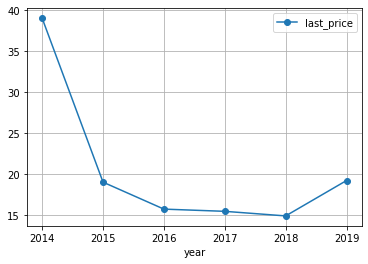

In [75]:
(centre_spb_data.pivot_table(index = ['year'], values = 'last_price') / 1000000).round(2).plot(style = '-o', grid = True)

- Год продажи: как и во всем городе, в центре квартиры были самыми дорогими в 2014, и точно так же снижались вплоть до 2018 и только в 2019 начали повышаться. Получается, год не щадит богатых и влияет на них ровно так же, как и на всех остальных!

## Общий вывод

Нам удалось выяснить:
- Центр города ограничен радиусом в 3 км.
- Что в Санкт-Петербурге и его окрестностях, как ни странно, сильное влияние на цену жилья оказывает: удаленность от центра, площадь квартиры и количество комнат (по сути, взаимосвязанные характеристики), однако в самом центре влияние удаленности не так заметно.
- Самый дешевый, вне зависимости от населенного пункта или части Питера, этаж это первый, а вот последний в центре города самый дорогой, а в остальных частях на втором месте, уступая пальму первенства этажам посередине.
- 2014 год - год самых высоких цен на недвижимость, а отрезок 2014-2018 сопровождался понижением средней цены на жилье в Питере.
- Цены в центре города значительно выше средних цен по городу, 9.8 млн против 4.5.
- Средняя цена кв.м. в северной столице в период с 2014 по 2019 составляла ~110 тыс. руб., а в Выборге, замыкающим топ-10 по количеству предложений на рынке недвижимости - 58 тыс. руб.
- Чрезычайно быстрой продажей квартиры можно считать срок в ~45 дней, а супердолгой около 500 дней.

In [76]:
print('Медиана по площади квартир в центре СПб:', centre_spb_data['total_area'].median(), 'кв.м.')
print('Медиана по площади квартир в Спб и окрестностях:', filtered_data['total_area'].median(), 'кв.м.')
print('Медианная цена на квартиру в центре СПб:', centre_spb_data['last_price'].median(), 'руб.')
print('Медианная цена на квартиру в Спб и окрестностях:', filtered_data['last_price'].median(), 'руб.')
print('Медиана по количеству комнат в центре СПб:', centre_spb_data['rooms'].median())
print('Медиана по количеству комнат в Спб и окрестностях:', filtered_data['rooms'].median())
print('Медианная высота потолков в центре СПб:', centre_spb_data['ceiling_height'].median(), 'м.')
print('Медианная высота потолков в Спб и окрестностях:', filtered_data['ceiling_height'].median(), 'м.')

Медиана по площади квартир в центре СПб: 85.0 кв.м.
Медиана по площади квартир в Спб и окрестностях: 50.5 кв.м.
Медианная цена на квартиру в центре СПб: 9825000.0 руб.
Медианная цена на квартиру в Спб и окрестностях: 4500000.0 руб.
Медиана по количеству комнат в центре СПб: 3.0
Медиана по количеству комнат в Спб и окрестностях: 2.0
Медианная высота потолков в центре СПб: 3.2 м.
Медианная высота потолков в Спб и окрестностях: 2.65 м.


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод